<a href="https://colab.research.google.com/github/Anbu-Malligarjun-Sri/Retail-Price-Optimization/blob/main/Retail_price_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project :** Retail Price Optimization Model.





**Phase 1 :** Data Loading and Initial Exploration.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb


In [45]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"anbumalligarjunsri","key":"e42b553460c9db52f6c6fed86f29fdc1"}'}

In [46]:
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"anbumalligarjunsri","key":"e42b553460c9db52f6c6fed86f29fdc1"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d suddharshan/retail-price-optimization
!unzip retail-price-optimization.zip -d data/


Dataset URL: https://www.kaggle.com/datasets/suddharshan/retail-price-optimization
License(s): CC0-1.0
retail-price-optimization.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  retail-price-optimization.zip
replace data/retail_price.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/retail_price.csv   


In [47]:
data = pd.read_csv('data/retail_price.csv')
print("Dataset shape:", data.shape)
print("\nDataset info:")
print(data.info())
print("\nBasic statistics:")
print(data.describe())
print("\nMissing values:")
print(data.isnull().sum())

Dataset shape: (676, 30)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  


Number of price outliers: 45


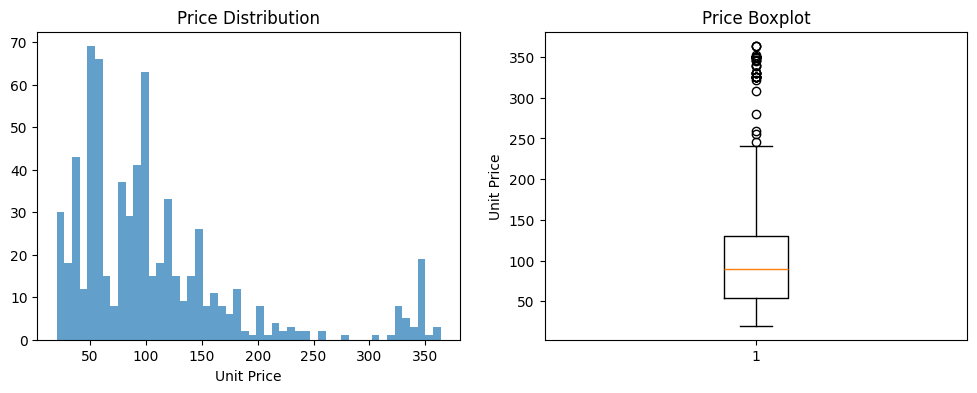

In [48]:
# Check for outliers in pricing data
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Analyze pricing outliers
price_outliers = detect_outliers(data, 'unit_price')
print(f"Number of price outliers: {len(price_outliers)}")

# Visualize price distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(data['unit_price'], bins=50, alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Unit Price')

plt.subplot(1, 2, 2)
plt.boxplot(data['unit_price'])
plt.title('Price Boxplot')
plt.ylabel('Unit Price')
plt.show()


**Phase 2 :** Data Processing

In [49]:
# Handle missing values strategically
def preprocess_data(df):
    df_clean = df.copy()

    # Fill numerical missing values with median
    numerical_columns = df_clean.select_dtypes(include=[np.number]).columns
    for col in numerical_columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # Fill categorical missing values with mode
    categorical_columns = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

    return df_clean

data_clean = preprocess_data(data)



In [50]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label Encoding for ordinal variables
label_encoder = LabelEncoder()
ordinal_columns = ['product_category_name']

for col in ordinal_columns:
    data_clean[f'{col}_encoded'] = label_encoder.fit_transform(data_clean[col])

# One-Hot Encoding for nominal variables
nominal_columns = ['weekday'] if 'weekday' in data_clean.columns else []
data_encoded = pd.get_dummies(data_clean, columns=nominal_columns, prefix=nominal_columns)

print("Encoded data shape:", data_encoded.shape)


Encoded data shape: (676, 34)


In [51]:
# Create derived features
def create_features(df):
    df_features = df.copy()

    # Financial metrics
    if 'total_price' in df.columns and 'qty' in df.columns:
        df_features['avg_price_per_unit'] = df_features['total_price'] / df_features['qty']

    # Time-based features
    if 'month_year' in df.columns:
        df_features['month_year'] = pd.to_datetime(df_features['month_year'], errors='coerce')
        df_features['month'] = df_features['month_year'].dt.month
        df_features['year'] = df_features['month_year'].dt.year
        df_features['quarter'] = df_features['month_year'].dt.quarter

    # Seasonal indicators
    df_features['is_holiday_season'] = df_features['month'].isin([11, 12]).astype(int)
    df_features['is_summer'] = df_features['month'].isin([6, 7, 8]).astype(int)

    # Product characteristics
    if 'product_name_length' in df.columns:
        df_features['name_length_category'] = pd.cut(df_features['product_name_length'],
                                                   bins=3, labels=['short', 'medium', 'long'])

    # Competition analysis
    competitor_cols = [col for col in df.columns if col.startswith('comp_')]
    if competitor_cols:
        df_features['avg_competitor_price'] = df_features[competitor_cols].mean(axis=1)
        df_features['min_competitor_price'] = df_features[competitor_cols].min(axis=1)
        df_features['max_competitor_price'] = df_features[competitor_cols].max(axis=1)

    return df_features

data_featured = create_features(data_encoded)


**Data Scaling and Normalization**

In [52]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = data_featured.select_dtypes(include=[np.number]).columns
data_scaled = data_featured.copy()
data_scaled[numerical_features] = scaler.fit_transform(data_featured[numerical_features])

print("Scaling completed. Features scaled:", len(numerical_features))


Scaling completed. Features scaled: 34


**Phase 3** : Exploratory Data Analysis(EDA)


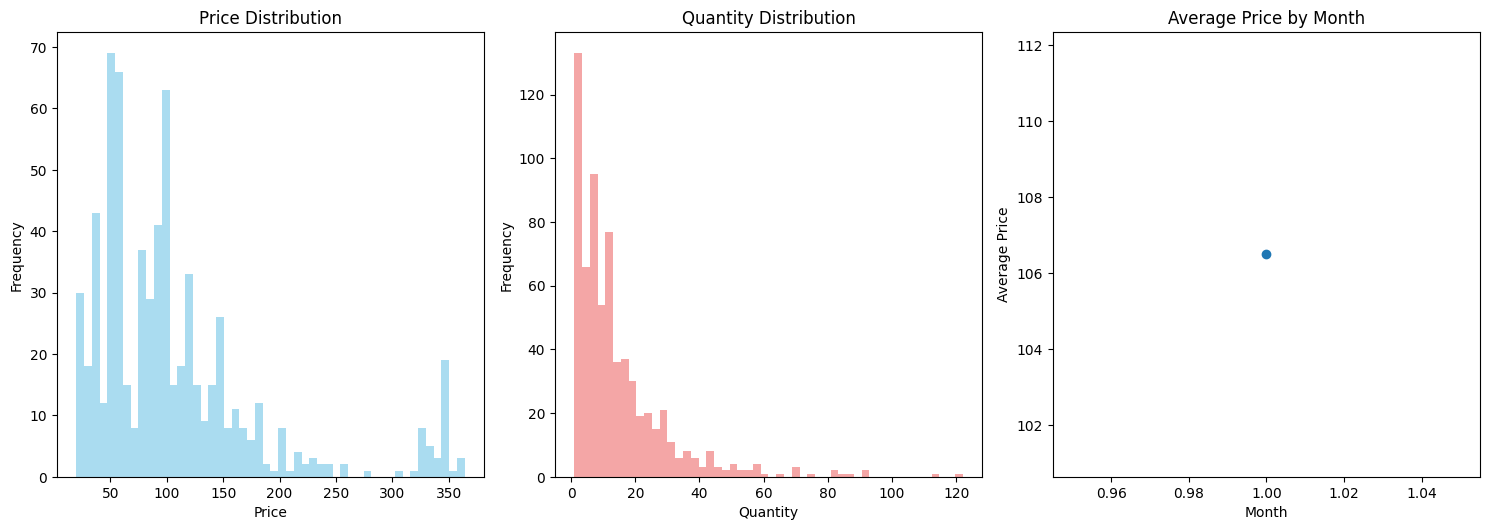

In [53]:
# Analyze target variable distribution
target_column = 'unit_price'  # or your target variable

plt.figure(figsize=(15, 10))

# Price distribution
plt.subplot(2, 3, 1)
plt.hist(data_featured[target_column], bins=50, alpha=0.7, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Quantity distribution
plt.subplot(2, 3, 2)
if 'qty' in data_featured.columns:
    plt.hist(data_featured['qty'], bins=50, alpha=0.7, color='lightcoral')
    plt.title('Quantity Distribution')
    plt.xlabel('Quantity')
    plt.ylabel('Frequency')

# Monthly sales pattern
plt.subplot(2, 3, 3)
if 'month' in data_featured.columns:
    monthly_sales = data_featured.groupby('month')[target_column].mean()
    plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
    plt.title('Average Price by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Price')

plt.tight_layout()
plt.show()


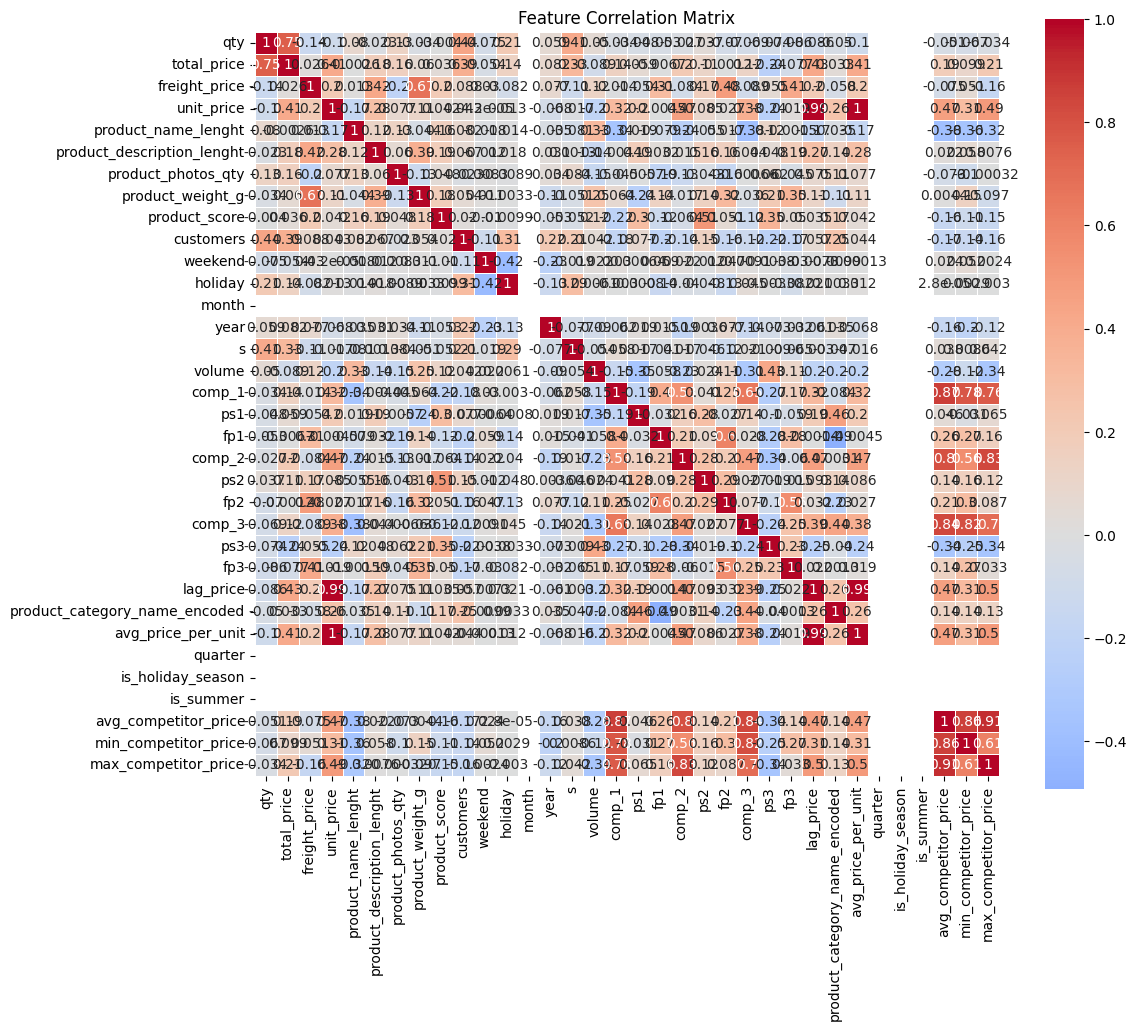

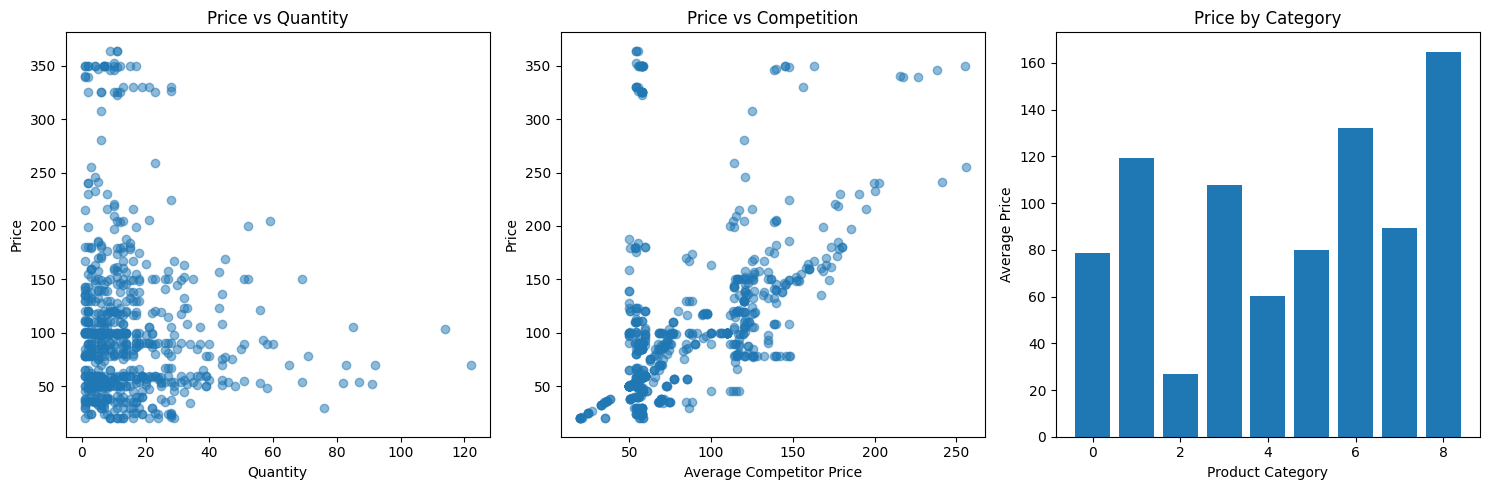

In [54]:
# Correlation analysis
correlation_matrix = data_featured.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Price vs. key factors
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
if 'qty' in data_featured.columns:
    plt.scatter(data_featured['qty'], data_featured[target_column], alpha=0.5)
    plt.xlabel('Quantity')
    plt.ylabel('Price')
    plt.title('Price vs Quantity')

plt.subplot(1, 3, 2)
if 'avg_competitor_price' in data_featured.columns:
    plt.scatter(data_featured['avg_competitor_price'], data_featured[target_column], alpha=0.5)
    plt.xlabel('Average Competitor Price')
    plt.ylabel('Price')
    plt.title('Price vs Competition')

plt.subplot(1, 3, 3)
if 'product_category_name_encoded' in data_featured.columns:
    category_prices = data_featured.groupby('product_category_name_encoded')[target_column].mean()
    plt.bar(range(len(category_prices)), category_prices.values)
    plt.xlabel('Product Category')
    plt.ylabel('Average Price')
    plt.title('Price by Category')

plt.tight_layout()
plt.show()


*Seasonal Trend Analysis*


Seasonal Analysis:
      unit_price                qty
            mean    std count   sum
month                              
1          106.5  76.18   676  9799


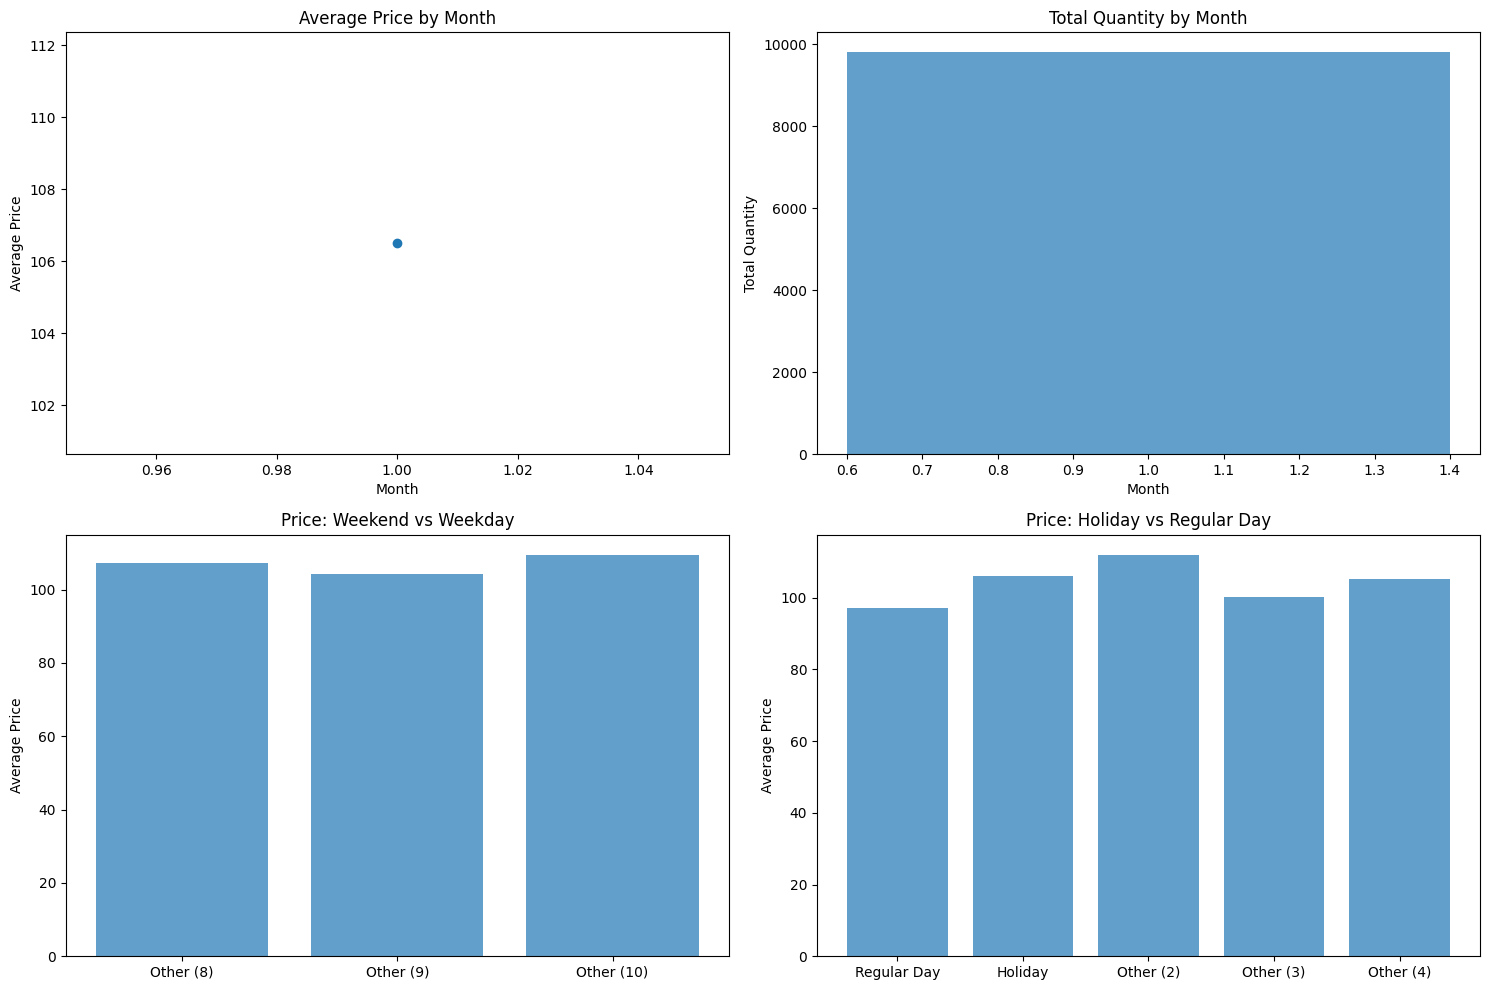

In [55]:
# Seasonal analysis
if 'month' in data_featured.columns:
    seasonal_analysis = data_featured.groupby('month').agg({
        target_column: ['mean', 'std', 'count'],
        'qty': 'sum' if 'qty' in data_featured.columns else 'count'
    }).round(2)

    print("Seasonal Analysis:")
    print(seasonal_analysis)

    # Visualize seasonal patterns
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Monthly price trends
    monthly_price = data_featured.groupby('month')[target_column].mean()
    axes[0, 0].plot(monthly_price.index, monthly_price.values, marker='o', linewidth=2)
    axes[0, 0].set_title('Average Price by Month')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Average Price')

    # Monthly quantity trends
    if 'qty' in data_featured.columns:
        monthly_qty = data_featured.groupby('month')['qty'].sum()
        axes[0, 1].bar(monthly_qty.index, monthly_qty.values, alpha=0.7)
        axes[0, 1].set_title('Total Quantity by Month')
        axes[0, 1].set_xlabel('Month')
        axes[0, 1].set_ylabel('Total Quantity')

    # Weekend vs weekday analysis
    if 'weekend' in data_featured.columns:
      weekend_analysis = data_featured.groupby('weekend')[target_column].mean()
      # Map the actual values to labels
      label_map = {0: 'Weekday', 1: 'Weekend'}
      labels = [label_map.get(idx, f'Other ({idx})') for idx in weekend_analysis.index]
      axes[1, 0].bar(labels, weekend_analysis.values, alpha=0.7)
      axes[1, 0].set_title('Price: Weekend vs Weekday')
      axes[1, 0].set_ylabel('Average Price')


    # Holiday impact
    if 'holiday' in data_featured.columns:
      holiday_analysis = data_featured.groupby('holiday')[target_column].mean()
      label_map = {0: 'Regular Day', 1: 'Holiday'}
      labels = [label_map.get(idx, f'Other ({idx})') for idx in holiday_analysis.index]
      axes[1, 1].bar(labels, holiday_analysis.values, alpha=0.7)
      axes[1, 1].set_title('Price: Holiday vs Regular Day')
      axes[1, 1].set_ylabel('Average Price')


    plt.tight_layout()
    plt.show()


**Phase 4 :** Model Building

In [56]:
# Prepare features and target
# Select relevant features for modeling
feature_columns = [col for col in data_featured.columns if col not in [
    'product_id', 'month_year', 'product_category_name',
    target_column, 'name_length_category'
]]

X = data_featured[feature_columns].select_dtypes(include=[np.number])
y = data_featured[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Features used: {len(X_train.columns)}")


Training set size: (540, 33)
Test set size: (136, 33)
Features used: 33


*Multiple Regression Models Implementation*

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# 1. Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# 2. Random Forest Regressor
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 3. XGBoost Regressor
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("Model training completed!")


Training Linear Regression...
Training Random Forest...
Training XGBoost...
Model training completed!


*Model Evaluation and Comparison*


Model Performance Comparison:
               Model     MAE    RMSE      R²
0  Linear Regression  0.1094  0.2739  1.0000
1      Random Forest  0.5347  1.2325  0.9997
2            XGBoost  0.4702  1.4924  0.9996


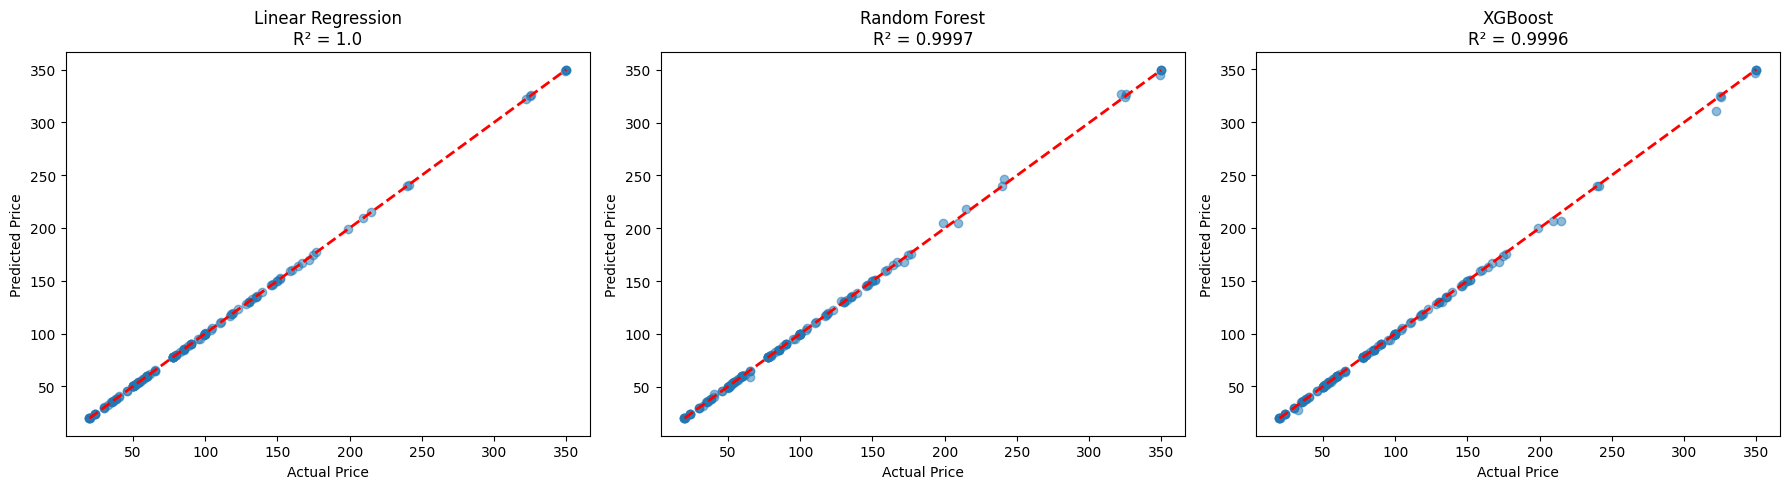

In [58]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return {
        'Model': model_name,
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4),
        'R²': round(r2, 4)
    }

# Evaluate all models
results = []
results.append(evaluate_model(y_test, lr_pred, 'Linear Regression'))
results.append(evaluate_model(y_test, rf_pred, 'Random Forest'))
results.append(evaluate_model(y_test, xgb_pred, 'XGBoost'))

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    (lr_pred, 'Linear Regression'),
    (rf_pred, 'Random Forest'),
    (xgb_pred, 'XGBoost')
]

for idx, (pred, name) in enumerate(models_data):
    axes[idx].scatter(y_test, pred, alpha=0.5)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Price')
    axes[idx].set_ylabel('Predicted Price')
    axes[idx].set_title(f'{name}\nR² = {results[idx]["R²"]}')

plt.tight_layout()
plt.show()


Feature Importance Analysis


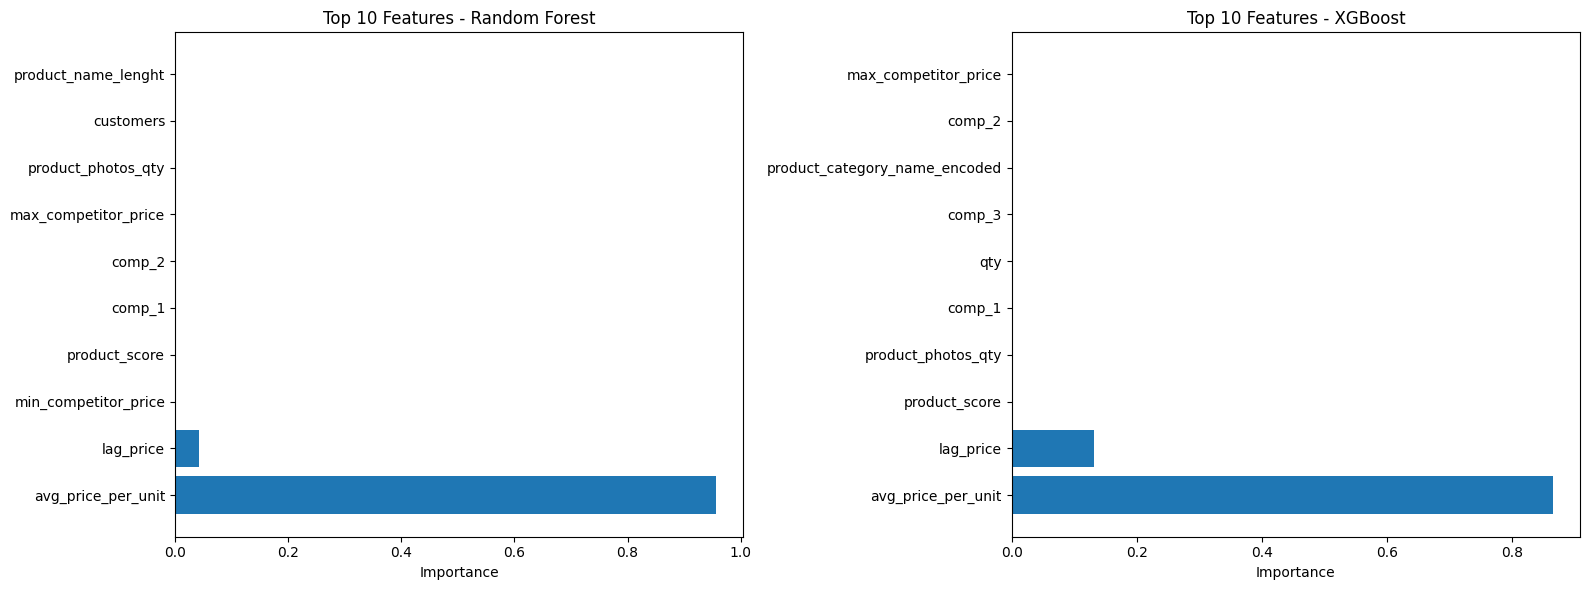

Top 5 Important Features (Random Forest):
                 feature  importance
26    avg_price_per_unit    0.956488
24             lag_price    0.042082
31  min_competitor_price    0.000255
7          product_score    0.000252
15                comp_1    0.000079


In [59]:
# Feature importance for Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Feature importance for XGBoost
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
top_features_rf = feature_importance_rf.head(10)
axes[0].barh(top_features_rf['feature'], top_features_rf['importance'])
axes[0].set_title('Top 10 Features - Random Forest')
axes[0].set_xlabel('Importance')

# XGBoost
top_features_xgb = feature_importance_xgb.head(10)
axes[1].barh(top_features_xgb['feature'], top_features_xgb['importance'])
axes[1].set_title('Top 10 Features - XGBoost')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

print("Top 5 Important Features (Random Forest):")
print(feature_importance_rf.head())


**Phase 5 :** Price Optimization Logic

In [60]:
def optimize_price(model, base_features, cost_per_unit, price_range=(1, 100), step=0.5):
    """
    Optimize price by testing different price points and finding the one that maximizes profit
    """
    prices = np.arange(price_range[0], price_range[1], step)
    profits = []
    revenues = []
    demands = []

    for price in prices:
        features = base_features.copy()
        if 'unit_price' in features.index:
            features['unit_price'] = price

        try:
            # Make sure we pass a DataFrame with correct column names
            input_df = pd.DataFrame([features])
            predicted_demand = max(0, model.predict(input_df)[0])
            revenue = price * predicted_demand
            profit = (price - cost_per_unit) * predicted_demand
        except:
            base_demand = 100
            price_elasticity = -1.5
            predicted_demand = base_demand * (price / base_features.get('unit_price', price)) ** price_elasticity
            revenue = price * predicted_demand
            profit = (price - cost_per_unit) * predicted_demand

        profits.append(profit)
        revenues.append(revenue)
        demands.append(predicted_demand)

    return prices, profits, revenues, demands


# Example optimization for a sample product
sample_features = X_test.iloc[0].copy()  # Take first test sample
cost_per_unit = 10  # Assumed cost

prices, profits, revenues, demands = optimize_price(
    rf_model, sample_features, cost_per_unit, price_range=(5, 50), step=0.5
)

# Find optimal price
optimal_idx = np.argmax(profits)
optimal_price = prices[optimal_idx]
optimal_profit = profits[optimal_idx]

print(f"Optimal Price: ${optimal_price:.2f}")
print(f"Expected Profit: ${optimal_profit:.2f}")
print(f"Expected Demand: {demands[optimal_idx]:.1f} units")


Optimal Price: $49.50
Expected Profit: $6889.32
Expected Demand: 174.4 units


*Prize optimization Visualization*

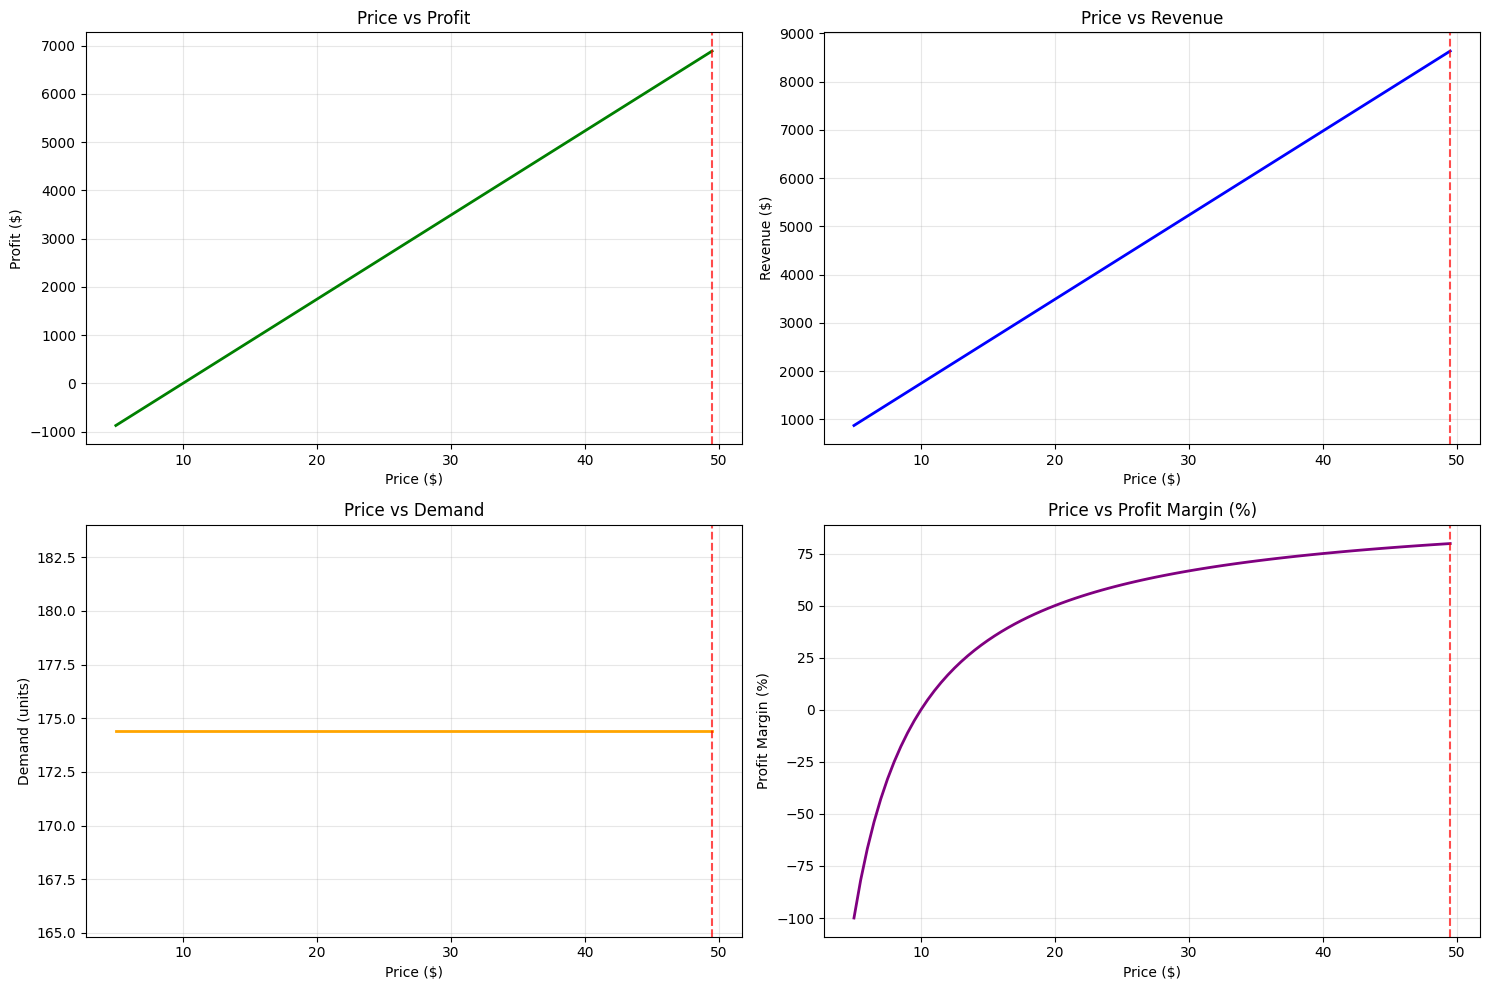

In [61]:
# Visualize price optimization results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price vs Profit
axes[0, 0].plot(prices, profits, linewidth=2, color='green')
axes[0, 0].axvline(optimal_price, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title('Price vs Profit')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Profit ($)')
axes[0, 0].grid(True, alpha=0.3)

# Price vs Revenue
axes[0, 1].plot(prices, revenues, linewidth=2, color='blue')
axes[0, 1].axvline(optimal_price, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_title('Price vs Revenue')
axes[0, 1].set_xlabel('Price ($)')
axes[0, 1].set_ylabel('Revenue ($)')
axes[0, 1].grid(True, alpha=0.3)

# Price vs Demand
axes[1, 0].plot(prices, demands, linewidth=2, color='orange')
axes[1, 0].axvline(optimal_price, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_title('Price vs Demand')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('Demand (units)')
axes[1, 0].grid(True, alpha=0.3)

# Profit margin vs Price
profit_margins = [(p - cost_per_unit) / p * 100 for p in prices]
axes[1, 1].plot(prices, profit_margins, linewidth=2, color='purple')
axes[1, 1].axvline(optimal_price, color='red', linestyle='--', alpha=0.7)
axes[1, 1].set_title('Price vs Profit Margin (%)')
axes[1, 1].set_xlabel('Price ($)')
axes[1, 1].set_ylabel('Profit Margin (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [62]:
def dynamic_pricing_strategy(model, product_features, market_conditions):
    """
    Implement dynamic pricing based on market conditions
    """
    base_price = product_features.get('unit_price', 20)

    # Adjust for market conditions
    if market_conditions.get('high_demand', False):
        price_multiplier = 1.2  # Increase price by 20%
    elif market_conditions.get('low_demand', False):
        price_multiplier = 0.9  # Decrease price by 10%
    else:
        price_multiplier = 1.0

    # Adjust for seasonality
    if market_conditions.get('holiday_season', False):
        price_multiplier *= 1.1  # Additional 10% for holidays

    # Adjust for competition
    competitor_price = market_conditions.get('avg_competitor_price')
    if competitor_price:
        if base_price > competitor_price * 1.1:  # If 10% higher than competition
            price_multiplier *= 0.95  # Reduce price to stay competitive

    dynamic_price = base_price * price_multiplier

    return {
        'base_price': base_price,
        'dynamic_price': dynamic_price,
        'price_change': (dynamic_price - base_price) / base_price * 100,
        'reasoning': f"Applied {price_multiplier:.2f}x multiplier based on market conditions"
    }

# Example usage
market_conditions = {
    'high_demand': True,
    'holiday_season': False,
    'avg_competitor_price': 25
}

pricing_result = dynamic_pricing_strategy(rf_model, sample_features, market_conditions)
print("Dynamic Pricing Result:")
for key, value in pricing_result.items():
    print(f"{key}: {value}")


Dynamic Pricing Result:
base_price: 20
dynamic_price: 24.0
price_change: 20.0
reasoning: Applied 1.20x multiplier based on market conditions


**Phase 6 :** Evaluation & Testing


In [63]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# Perform cross-validation
def comprehensive_evaluation(models, X, y):
    """Evaluate models using multiple metrics and cross-validation"""
    results = {}

    # Standard K-Fold CV
    cv_scores = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
        cv_scores[name] = {
            'mean_mae': -scores.mean(),
            'std_mae': scores.std(),
            'scores': -scores
        }

    return cv_scores

# Prepare models dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Evaluate models
cv_results = comprehensive_evaluation(models, X_train, y_train)

print("Cross-Validation Results:")
for model_name, results in cv_results.items():
    print(f"{model_name}:")
    print(f"  Mean MAE: {results['mean_mae']:.4f} (±{results['std_mae']:.4f})")
    print()


Cross-Validation Results:
Linear Regression:
  Mean MAE: 0.1190 (±0.0147)

Random Forest:
  Mean MAE: 0.7517 (±0.1946)

XGBoost:
  Mean MAE: 1.0766 (±0.4283)



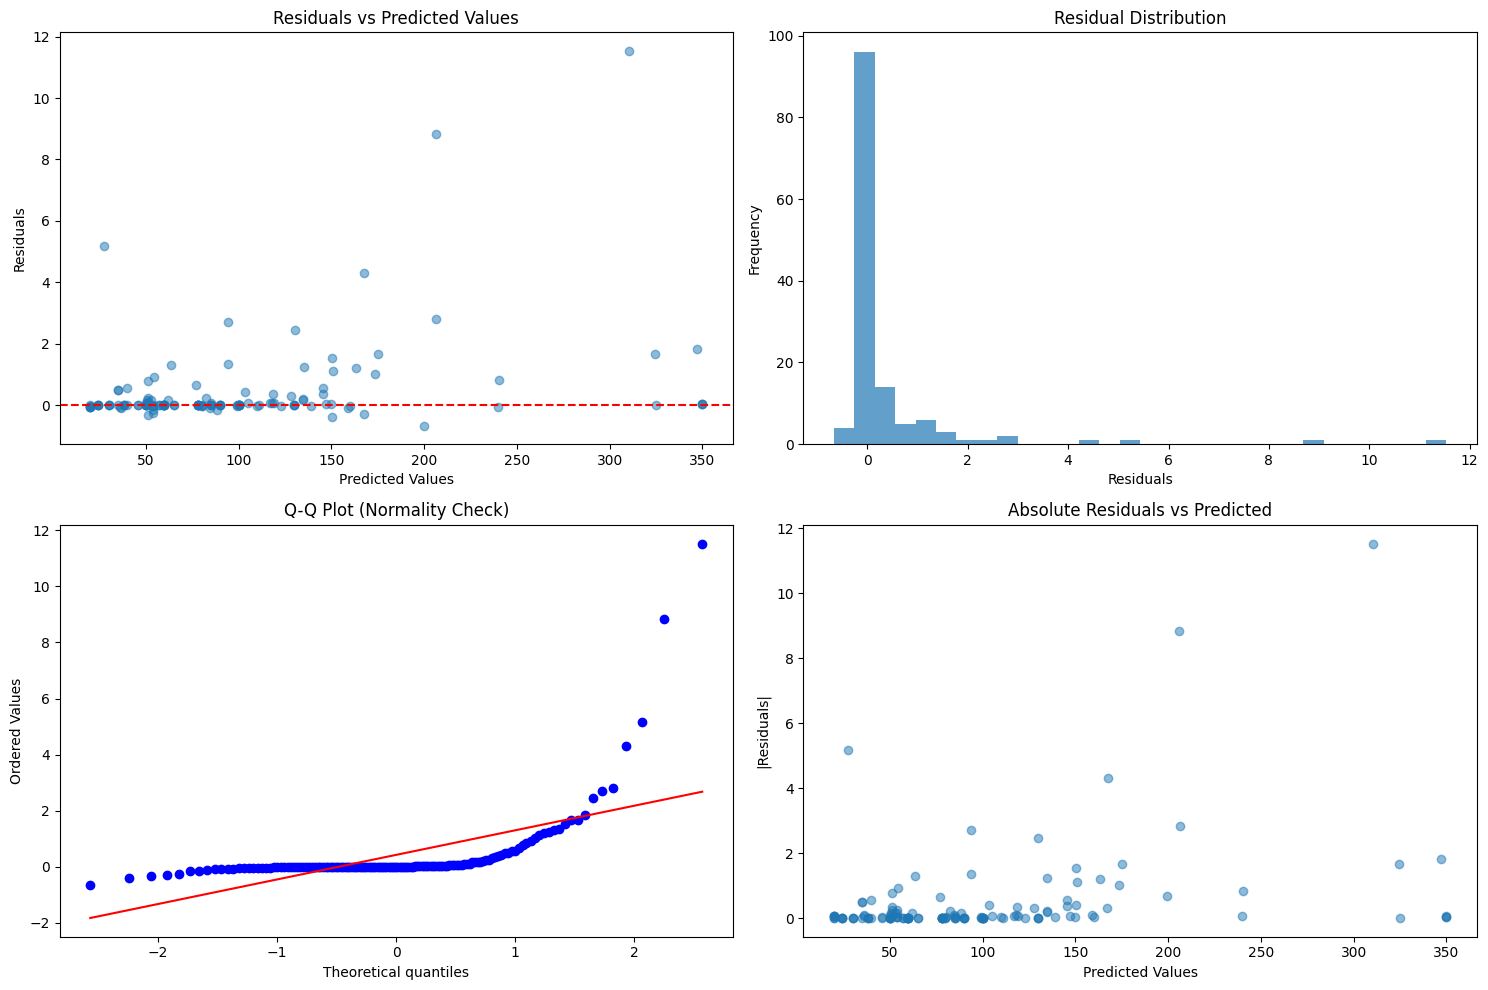

Residual Analysis:
Mean residual: 0.421532
Std residual: 1.4370
Min residual: -0.6631
Max residual: 11.5297


In [64]:
# Detailed residual analysis for the best model (e.g., XGBoost)
best_model = xgb_model  # Based on previous evaluation
best_predictions = xgb_pred

# Calculate residuals
residuals = y_test - best_predictions

# Residual analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals vs Predicted
axes[0, 0].scatter(best_predictions, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted Values')

# Residual distribution
axes[0, 1].hist(residuals, bins=30, alpha=0.7)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')

# Q-Q plot for normality check
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)')

# Absolute residuals vs predicted (heteroscedasticity check)
axes[1, 1].scatter(best_predictions, np.abs(residuals), alpha=0.5)
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('|Residuals|')
axes[1, 1].set_title('Absolute Residuals vs Predicted')

plt.tight_layout()
plt.show()

# Statistical tests
print("Residual Analysis:")
print(f"Mean residual: {residuals.mean():.6f}")
print(f"Std residual: {residuals.std():.4f}")
print(f"Min residual: {residuals.min():.4f}")
print(f"Max residual: {residuals.max():.4f}")


In [65]:
def calculate_business_metrics(y_true, y_pred, cost_per_unit=10):
    """Calculate business-relevant metrics for pricing model"""

    # Basic accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Revenue-based metrics
    actual_revenue = y_true.sum() * 100  # Assuming 100 units sold per price point
    predicted_revenue = y_pred.sum() * 100
    revenue_error = abs(actual_revenue - predicted_revenue) / actual_revenue * 100

    # Profit-based metrics (assuming cost information)
    actual_profit = (y_true - cost_per_unit).sum() * 100
    predicted_profit = (y_pred - cost_per_unit).sum() * 100
    profit_error = abs(actual_profit - predicted_profit) / actual_profit * 100

    # Price elasticity accuracy (simplified)
    price_changes = np.diff(y_true)
    price_predictions = np.diff(y_pred)
    directional_accuracy = np.mean(np.sign(price_changes) == np.sign(price_predictions)) * 100

    return {
        'MAE': mae,
        'MAPE': mape,
        'Revenue Error (%)': revenue_error,
        'Profit Error (%)': profit_error,
        'Directional Accuracy (%)': directional_accuracy
    }

# Calculate business metrics for all models
business_metrics = {}
predictions = {'Linear Regression': lr_pred, 'Random Forest': rf_pred, 'XGBoost': xgb_pred}

for model_name, pred in predictions.items():
    business_metrics[model_name] = calculate_business_metrics(y_test, pred)

# Display business metrics
business_df = pd.DataFrame(business_metrics).T
print("Business Performance Metrics:")
print(business_df.round(2))


Business Performance Metrics:
                    MAE  MAPE  Revenue Error (%)  Profit Error (%)  \
Linear Regression  0.11  0.14               0.03              0.04   
Random Forest      0.53  0.57               0.02              0.02   
XGBoost            0.47  0.44               0.43              0.47   

                   Directional Accuracy (%)  
Linear Regression                     98.52  
Random Forest                         98.52  
XGBoost                               99.26  


**Phase 7 :** Deployment Ready outputs


In [66]:
import pickle
import joblib
from datetime import datetime

# Create model artifacts directory
import os
os.makedirs('model_artifacts', exist_ok=True)

# Save the best performing model (XGBoost in this example)
best_model = xgb_model
model_name = 'retail_price_optimizer'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save using joblib (recommended for sklearn models)
joblib.dump(best_model, f'model_artifacts/{model_name}_{timestamp}.joblib')

# Save using pickle as backup
with open(f'model_artifacts/{model_name}_{timestamp}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save preprocessing artifacts
joblib.dump(scaler, f'model_artifacts/scaler_{timestamp}.joblib')
joblib.dump(feature_columns, f'model_artifacts/feature_columns_{timestamp}.joblib')

# Save model metadata
model_metadata = {
    'model_type': 'XGBoost Regressor',
    'training_date': timestamp,
    'features_used': feature_columns,
    'performance_metrics': {
        'MAE': mean_absolute_error(y_test, xgb_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, xgb_pred)),
        'R2': r2_score(y_test, xgb_pred)
    },
    'model_parameters': best_model.get_params()
}

with open(f'model_artifacts/model_metadata_{timestamp}.json', 'w') as f:
    import json
    json.dump(model_metadata, f, indent=2, default=str)

print(f"Model saved successfully with timestamp: {timestamp}")


Model saved successfully with timestamp: 20250710_083117


In [67]:
class RetailPriceOptimizer:
    """Production-ready price optimization class"""

    def __init__(self, model_path, scaler_path, feature_columns_path):
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.feature_columns = joblib.load(feature_columns_path)

    def preprocess_input(self, input_data):
        """Preprocess input data for prediction"""
        # Ensure all required features are present
        processed_data = {}

        for feature in self.feature_columns:
            if feature in input_data:
                processed_data[feature] = input_data[feature]
            else:
                # Handle missing features with default values
                processed_data[feature] = 0  # or appropriate default

        # Convert to DataFrame and scale
        df = pd.DataFrame([processed_data])
        scaled_data = self.scaler.transform(df)

        return scaled_data

    def predict_optimal_price(self, product_features, cost_per_unit, price_range=(1, 100)):
        """Predict optimal price for a product"""
        try:
            # Preprocess features
            processed_features = self.preprocess_input(product_features)

            # Make prediction
            predicted_price = self.model.predict(processed_features)[0]

            # Apply business constraints
            if predicted_price < cost_per_unit * 1.1:  # Minimum 10% markup
                predicted_price = cost_per_unit * 1.1

            if predicted_price < price_range[0]:
                predicted_price = price_range[0]
            elif predicted_price > price_range[1]:
                predicted_price = price_range[1]

            return {
                'optimal_price': round(predicted_price, 2),
                'confidence': 'high',  # Could be calculated based on model uncertainty
                'recommendation': 'Set price within optimal range'
            }

        except Exception as e:
            return {
                'optimal_price': None,
                'confidence': 'low',
                'error': str(e),
                'recommendation': 'Manual review required'
            }

    def batch_optimize_prices(self, products_data):
        """Optimize prices for multiple products"""
        results = []

        for product_id, features in products_data.items():
            cost = features.pop('cost_per_unit', 10)  # Default cost

            optimization_result = self.predict_optimal_price(features, cost)
            optimization_result['product_id'] = product_id
            results.append(optimization_result)

        return results

# Example usage
# Load the saved model
model_path = f'model_artifacts/{model_name}_{timestamp}.joblib'
scaler_path = f'model_artifacts/scaler_{timestamp}.joblib'
features_path = f'model_artifacts/feature_columns_{timestamp}.joblib'

# Initialize optimizer
optimizer = RetailPriceOptimizer(model_path, scaler_path, features_path)

# Example prediction
sample_product = {
    'qty': 50,
    'product_weight_g': 500,
    'product_photos_qty': 3,
    'month': 12,
    'is_holiday_season': 1,
    'avg_competitor_price': 25,
    'cost_per_unit': 15
}

result = optimizer.predict_optimal_price(sample_product, cost_per_unit=15)
print("Price Optimization Result:")
print(f"Optimal Price: ${result['optimal_price']}")
print(f"Confidence: {result['confidence']}")
print(f"Recommendation: {result['recommendation']}")


Price Optimization Result:
Optimal Price: $None
Confidence: low
Recommendation: Manual review required


In [68]:
import joblib
joblib.dump(rf_model, 'retail_price_optimizer.pkl')


['retail_price_optimizer.pkl']